In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.interpolate import interp1d

from src.colorconv import ConvexCluster
from src.util import (non_dominated_front,
                      compression,
                      informativeness)

In [3]:
# unpockle IB_color_naming.pkl from data
with open('data/IB_color_naming.pkl', 'rb') as f:
    IB_color_naming = pickle.load(f)

# unpickle chip dict
with open('data/chip_dict.pkl', 'rb') as f:
    chip_dict = pickle.load(f)

# unpickle sielab_dict
with open('data/cielab_dict.pkl', 'rb') as f:
    cielab_dict = pickle.load(f)   

In [4]:
prior_m = IB_color_naming['pM']

# match index of prior_m to chip_dict coordinates 
# and build a new dict (coordinate: probability)
prior_m_ = []
for i, p in enumerate(prior_m):
    prior_m_.append((chip_dict[i+1], p))

# remove entries with first coordinate == 1
prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# use coordinate from prior_m_ to build a matrix with probabilities
prior_m_matrix = np.zeros((8, 40))
for c, p in prior_m_:
    prior_m_matrix[c[0]-1, c[1]-1] = p

In [5]:
# only choose coordinates in the range (0, 0), (8, 40)
cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# reverse keys and values in cielab_dict_
cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

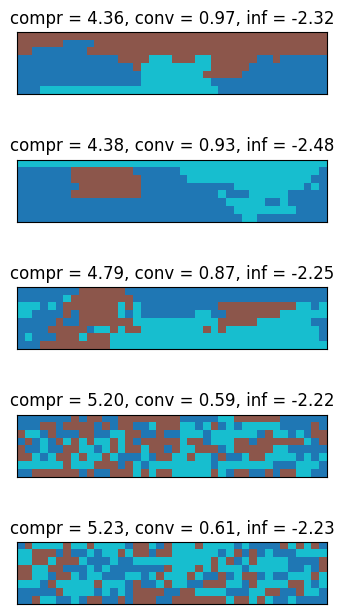

In [6]:
# just change convexity in the range 0.05 - 1
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]

fig, ax = plt.subplots(5, 1, figsize=(4, 8))

for j, conn in enumerate(conn_values):
    a = ConvexCluster(X = np.zeros((8, 40)), 
                        d = 8, 
                        N = 3, 
                        s = 0.5, 
                        c = conn,
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
    labels = a.run()
    ax[j].imshow(labels, cmap='tab10', interpolation='none')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f'compr = {compression(labels):.2f}, '
                    f'conv = {a.degree_of_convexity():.2f}, ' 
                    f'inf = {informativeness(labels, prior_m_matrix, cielab_dict):.2f}')

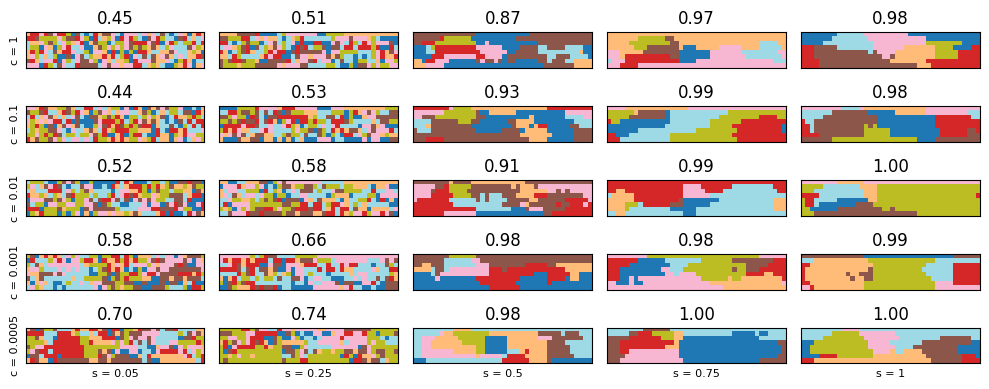

In [7]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(5, 5, figsize=(10, 4))

smooth_values = [0.05, 0.25, 0.5, 0.75, 1]
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros((8, 40)), 
                         d = 1.5, 
                         N = 7, 
                         s = smooth, 
                         c = conn,
                         coords=cielab_list,
                         reverse_labels=cielab_dict_r)
        labels = a.run()
        ax[i, j].imshow(labels, 
                        cmap='tab20', 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'{a.degree_of_convexity():.2f}')
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c = ' + str(conn), fontsize=8)

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[4, j].set_xlabel('s = ' + str(smooth), fontsize=8)

plt.tight_layout()
# save the plot as pdf
plt.savefig('figures/convex_clusters.pdf')
plt.show()

In [8]:
def generate_grid(n, n_low, n_high, d = 2, X = 10, Y = 10):
    s_values = np.random.uniform(0.8, 1, n)
    c_values = np.random.uniform(0, 0.1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []
    param_dict = {}
    lgs = []

    for i, sc in enumerate(zip(s_values, c_values)):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = sc[0], 
                        c = sc[1],
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
        l = a.run()
        
        lgs.append(l)
        param_dict[i] = (sc[0], sc[1], N)
        mdl_values.append(compression(l))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(l, 
                                           prior_m_matrix, 
                                           cielab_dict))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ, param_dict, lgs

In [9]:
results = generate_grid(n = 30000, 
                        d = 2, 
                        X = 8,
                        Y = 40,
                        n_low = 3,
                        n_high = 15)

In [10]:
mdl_values, conv_values, cost_values, categ, param_dict, lgs = results

In [11]:
# dump results to pickle
with open('data/convex_cluster_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [12]:
# iterate over cost_values, if a value is inf, then remove it from the list and from the other lists
for i, val in enumerate(cost_values):
    if np.isinf(val):
        mdl_values.pop(i)
        conv_values.pop(i)
        categ.pop(i)
        cost_values.pop(i)

In [13]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [14]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto)

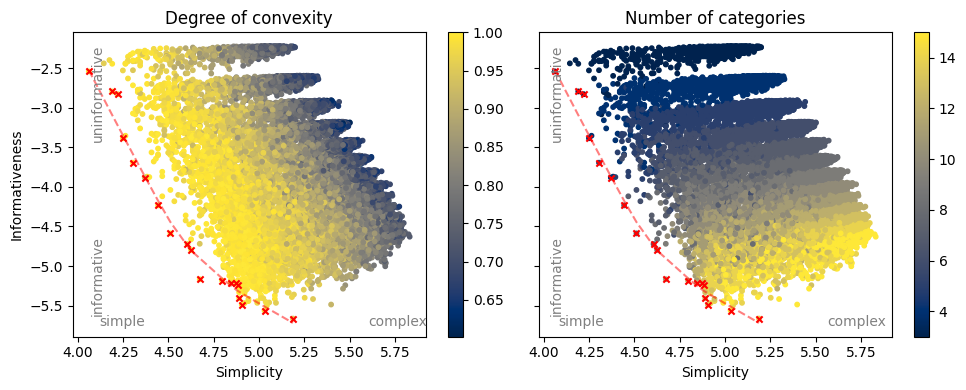

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)

# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax1.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
ax1.text(-1.25, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.25, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.18, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.4, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity')
cbar1 = fig.colorbar(scatter1, ax=ax1)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
# ax2.set_xlabel('simple <------------------------> complex')
# add text in the top and bottom left corner
ax2.text(0.05, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.05, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.12, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.text(0.9, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories')
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2)



plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/convexity_categories_comparison.pdf')
plt.show()

In [16]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2)))

In [17]:
df = pd.DataFrame({'convexity': conv_values,
                   'categories': categ,
                   'distance': distances})

In [18]:
# standardize categories and convexity
df['categories'] = (df['categories'] - df['categories'].mean()) / df['categories'].std()
df['convexity'] = (df['convexity'] - df['convexity'].mean()) / df['convexity'].std()

In [19]:
# statsmodels regression predicting distance from convexity and number of categories

# remove nan or inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df[['convexity', 'categories']]
y = df['distance']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

In [20]:
# summarize our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                 6.085e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:00:29   Log-Likelihood:                 24422.
No. Observations:               30000   AIC:                        -4.884e+04
Df Residuals:                   29997   BIC:                        -4.881e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9715      0.001   1569.469      0.000       0.970       0.973
convexity     -0.2205      0.001   -348.833      0.000      -0.222      -0.219
categories     0.0430      0.001     68.025      0.000       0.042       0.044
==============================================================================
Omnibus:                     2897.715   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5235.954
Skew:                          -0.670   Prob(JB):                         0.00
Kurtosis:                       4.547   Cond. No.                         1.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

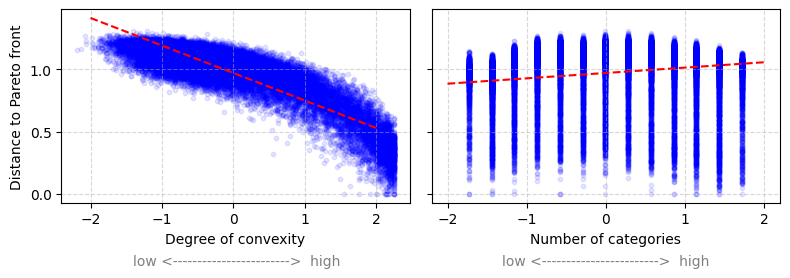

In [21]:
# plot convexity vs distance and categories vs distance in one plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot convexity vs distance
ax1.scatter(df['convexity'], df['distance'], alpha=0.1, color='b', s=10)
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')
ax1.text(-0.56, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')
# plot model prediction
x = np.linspace(-2, 2, 100)
y = model.params[0] + model.params[1] * x
ax1.plot(x, y, 'r--', alpha=1)

# Plot categories vs distance
ax2.scatter(df['categories'], df['distance'], alpha=0.1, color='b', s=10)
ax2.grid(linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of categories')
# add subscript (low <---> high) below the x-axis
ax2.text(0.5, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')
# plot model prediction
x = np.linspace(-2, 2, 100)
y = model.params[0] + model.params[2] * x
ax2.plot(x, y, 'r--', alpha=1)
        

plt.tight_layout()
plt.show()

In [22]:
with open('data/lg_color.pkl', 'rb') as f:
    lg_color = pickle.load(f)

In [23]:
# enumerate over grids in lg_color and calculate informativeness
informativeness_values = []
simplicity_values = []
categ_values = []

for grid in lg_color:
    informativeness_values.append(informativeness(lg_color[grid], prior_m_matrix, cielab_dict))
    simplicity_values.append(compression(lg_color[grid]))
    categ_values.append(len(np.unique(lg_color[grid])))

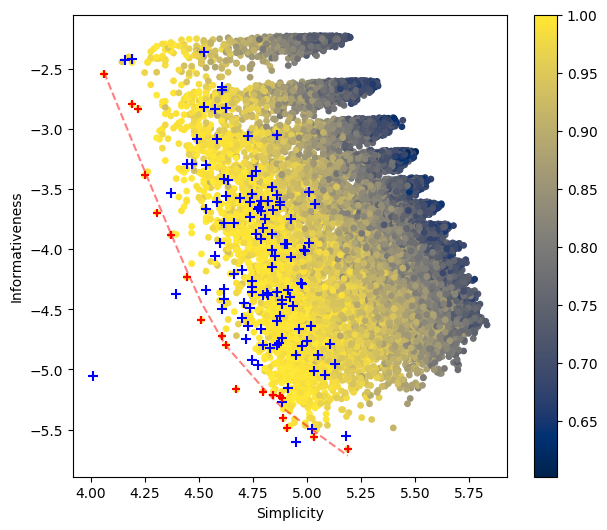

In [65]:
plt.figure(figsize=(7, 6))
plt.scatter(mdl_values, cost_values, c=conv_values, cmap='cividis', alpha=1, s = 15, marker = 'o')
plt.colorbar(alpha=1)
plt.scatter(simplicity_values, informativeness_values, c='blue', marker='+', s=60)
plt.scatter(*zip(*pareto_front_points),
            c='red', 
            marker='+',
            s=30)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
plt.ylabel('Informativeness')
plt.xlabel('Simplicity')
plt.savefig('figures/WCS_comparison.pdf')
plt.show()

In [25]:
# count the number of unique values in each grid in lg_color
unique_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# print min and max
print(min(unique_values), max(unique_values))

3 15


In [26]:
# pareto_front_indices = non_dominated_front(categ, [-np.log(-1 * i) for i in cost_values])
# pareto_front_points = [(categ[i], [-np.log(-1 * i) for i in cost_values][i]) for i in pareto_front_indices]

# # find duplicates in either x or y and remove them
# pareto_front_points = list(set(pareto_front_points))

# x_pareto, y_pareto = zip(*pareto_front_points)

# # create a smooth line over x_pareto and y_pareto using lowess
# lowess = sm.nonparametric.lowess
# smoothed = lowess(y_pareto, x_pareto, frac=0.7)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_3555/2864051231.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(categ, cost_values, c='grey', cmap='cividis', alpha=0.1,


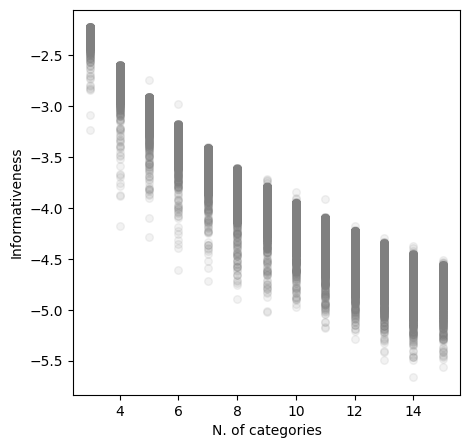

In [27]:
plt.figure(figsize=(5, 5))
plt.scatter(categ, cost_values, c='grey', cmap='cividis', alpha=0.1,
                       s = 30, marker = 'o')
# plt.colorbar(alpha=1)
# plt.scatter(*zip(*pareto_front_points),
#             c='red', 
#             marker='x',
#             s=20)
# plt.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
# plt.scatter(categ_values, informativeness_values, c='red', marker='+', s=30)
# plt.gca().invert_yaxis()
plt.ylabel('Informativeness')
plt.xlabel('N. of categories')
# plt.yscale('log')
plt.show()

In [28]:
def plot_n_neighbours(idx_list, n):
    k = len(idx_list)  # Number of indices in the list
    fig, ax = plt.subplots(n, k)  # Adjust figsize as needed

    for col, idx in enumerate(idx_list):
        distances = []
        comp = compression(lg_color[idx])
        info = informativeness(lg_color[idx], prior_m_matrix, cielab_dict)

        for i, j in zip(mdl_values, cost_values):
            distances.append(np.sqrt((i - comp)**2 + (j - info)**2))

        # Sort distances (from smallest to largest) and get the indices
        nearest_indices = np.argsort(distances)[:n]

        for row, nearest_idx in enumerate(nearest_indices):
            if row == 0:
                ax[row, col].set_title(f'Language {idx}')
                ax[row, col].imshow(lg_color[idx], cmap='tab10', interpolation='none')
            else:
                ax[row, col].set_title(f'Nearest {row}')
                ax[row, col].imshow(lgs[nearest_idx], cmap='tab10', interpolation='none')
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])

    plt.tight_layout()
    plt.show()


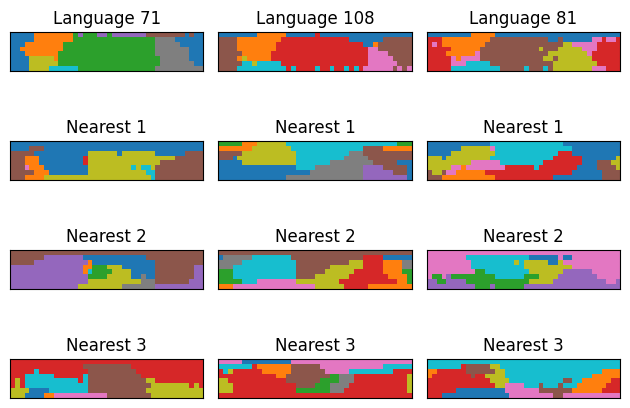

In [58]:
# Sample 3 random indexes
random_indexes = np.random.choice(len(lg_color), 3, replace=False)

# Plot nearest neighbors
plot_n_neighbours(random_indexes, 4)

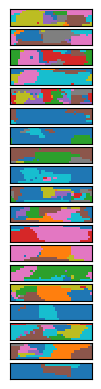

In [53]:
# plot lgs in th epareto front
fig, ax = plt.subplots(len(pareto_front_indices), 1)
for i, ax in enumerate(ax):
    ax.imshow(lgs[pareto_front_indices[i]], cmap='tab10', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title(f'{mdl_values[pareto_front_indices[i]]:.2f} :: '
    #              f'{cost_values[pareto_front_indices[i]]:.2f}')
# plt.tight_layout()
# save to pdf
plt.savefig('figures/pareto_front_lgs.pdf', bbox_inches='tight')
plt.show()

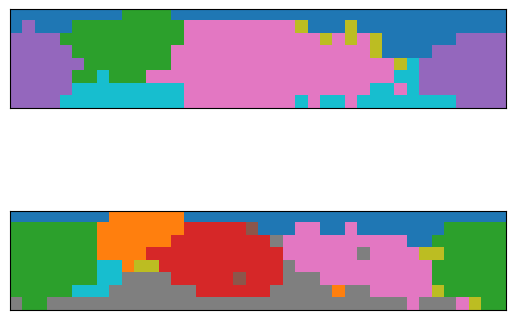

In [37]:
# plot the language with the lowest complexity from real languages
# mdl_index = np.argmin(simplicity_values)
# index the first two smallest values from simplicity_values
mdl_index = np.argsort(simplicity_values)[:2]
# plot the labgugge with the lowest mdl
fig, ax = plt.subplots(2, 1)
for i in range(2):
    ax[i].imshow(lg_color[mdl_index[i]], cmap='tab10', interpolation='none')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()